In [3]:
#imports
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras as K
import matplotlib.pyplot as plt

In [ ]:
# Task 0. Convolutional Forward Prop
"""
Write a function that performs forward propagation over a convolutional layer
of a neural network.
"""
def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c_prev) containing the
    output of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c_prev: number of channels in the previous layer
    W: numpy.ndarray of shape (kh, kw, c_prev, c_new) containing the kernels
    for the convolution
        kh: filter height
        kw: filter width
        c_prev: number of channels in the previous layer
        c_new: number of channels in the output
    b: numpy.ndarray of shape (1, 1, 1, c_new) containing the biases applied
    to the convolution
    activation: an activation function applied to the convolution
    padding: string that is either 'same' or 'valid' indicating the type of
    padding used
    stride: tuple of shape (sh, sw) containing the strides for the convolution
        sh: stride for the height
        sw: stride for the width
    Returns the output of the convolution layer
    """

    m = A_prev.shape[0]
    h_prev = A_prev.shape[1]
    w_prev = A_prev.shape[2]
    c_prev = A_prev.shape[3]

    kh = W.shape[0]
    kw = W.shape[1]
    kc_prev = W.shape[2]
    kc_new = W.shape[3]

    sh = stride[0]
    sw = stride[1]

    if padding == 'same':
        pad_top_bottom = (((h_prev - 1) * sh) + kh - h_prev) // 2
        pad_left_right = (((w_prev - 1) * sw) + kw - w_prev) // 2

    if padding == 'valid':
        pad_top_bottom = 0
        pad_left_right = 0

    A_prev = np.pad(A_prev, ((0, 0), (pad_top_bottom, pad_top_bottom),
                                 (pad_left_right, pad_left_right), (0, 0)))

    h_prev = (h_prev + 2 * pad_top_bottom - kh) // sh + 1
    w_prev = (w_prev + 2 * pad_left_right - kw) // sw + 1

    conv_image = np.zeros((m, h_prev, w_prev, kc_new))

    for x in range (h_prev):
        for y in range (w_prev):
            for z in range (kc_new):
                i = x * sh
                j = y * sw
                hadamard_prod = np.multiply(A_prev[:, i:i + kh, j:j + kw, :],
                                            W[:, :, :, z])
                conv_image[:, x, y, z] = np.sum(hadamard_prod, axis=(1, 2, 3))

    return activation(conv_image + b)

In [ ]:
# 0-main
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

def relu(Z):
    return np.maximum(Z, 0)

plt.imshow(X_train[0])
plt.show()
A = conv_forward(X_train_c, W, b, relu, padding='valid')
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()

In [ ]:
# Task 1. Pooling Forward Prop
"""
Write a function that performs forward propagation over a pooling layer of a
neural network
"""
def pool_forward(A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c_prev) containing the
    output of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c_prev: number of channels in the previous layer
    kernel_shape: numpy.ndarray of shape (kh, kw) containing the kernels
    for the convolution
        kh: filter height
        kw: filter width
    stride: tuple of shape (sh, sw) containing the strides for the convolution
        sh: stride for the height
        sw: stride for the width
    mode: string containing either 'max' or 'avg', indicating whether to
    perform maximum or average pooling
    Returns the output of the pooling layer
    """
    m = A_prev.shape[0]
    h = A_prev.shape[1]
    w = A_prev.shape[2]
    c = A_prev.shape[3]

    kh = kernel_shape[0]
    kw = kernel_shape[1]

    sh = stride[0]
    sw = stride[1]

    h = (h - kh) // sh + 1
    w = (w - kw) // sw + 1

    output_image = np.zeros((m, h, w, c))

    for x in range(h):
        for y in range(w):
            i = x * sh
            j = y * sw
            if mode == 'max':
                output_image[:, x, y, :] = np.max(A_prev[:,
                                                         i:i + kh,
                                                         j:j + kw,
                                                         :], axis=(1, 2))
            if mode == 'avg':
                output_image[:, x, y, :] = np.mean(A_prev[:,
                                                          i:i + kh,
                                                          j:j + kw,
                                                          :], axis=(1, 2))
    return output_image

In [ ]:
# 1-main
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_a = X_train.reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

print(X_train_c.shape)
plt.imshow(X_train_c[0, :, :, 0])
plt.show()
plt.imshow(X_train_c[0, :, :, 1])
plt.show()
A = pool_forward(X_train_c, (2, 2), stride=(2, 2))
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()

In [ ]:
# Task 2. Convolutional Back Prop
"""
Write a function that performs back propagation over a convolutional layer of
a neural network
"""
def conv_backward(dZ, A_prev, W, b, padding="same", stride=(1, 1)):
    """
    dZ: numpy.ndarray of shape (m, h_new, w_new, c_new) containing the partial
    derivatives with respect to the unactivated output of the convolutional
    layer
        m: number of examples
        h_new: height of the output
        w_new: width of the output
        c_new: number of channels in the output
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c_prev) containing the
    output of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c_prev: number of channels in the previous layer
    W: numpy.ndarray of shape (kh, kw, c_prev, c_new) containing the kernels
    for the convolution
        kh: filter height
        kw: filter width
        c_prev: number of channels in the previous layer
        c_new: number of channels in the output
    b: numpy.ndarray of shape (1, 1, 1, c_new) containing the biases applied
    to the convolution
    stride: tuple of shape (sh, sw) containing the strides for the convolution
        sh: stride for the height
        sw: stride for the width
    Returns the partial derivatives with respect to the previous layer
    (dA_prev), the kernels (dW) and the biases(db), respectively
    """
    m = dZ.shape[0]
    h_new = dZ.shape[1]
    w_new = dZ.shape[2]
    c_new = dZ.shape[3]

    h_prev = A_prev.shape[1]
    w_prev = A_prev.shape[2]
    c_prev = A_prev.shape[3]

    kh = W.shape[0]
    kw = W.shape[1]

    sh = stride[0]
    sw = stride[1]

    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)

    if padding == 'same':
        pad_top_bottom = (((h_prev - 1) * sh) + kh - h_prev) // 2 + 1
        pad_left_right = (((w_prev - 1) * sw) + kw - w_prev) // 2 + 1

    if padding == 'valid':
        pad_top_bottom = 0
        pad_left_right = 0

    A_prev = np.pad(A_prev, ((0, 0), (pad_top_bottom, pad_top_bottom),
                    (pad_left_right, pad_left_right), (0, 0)))

    dA_prev = np.pad(dA_prev, ((0, 0), (pad_top_bottom, pad_top_bottom),
                (pad_left_right, pad_left_right), (0, 0)))

    for image in range(m):
        for x in range (h_new):
            for y in range (w_new):
                for z in range (c_new):
                    i = x * sh
                    j = y * sw
                    dW[:, :, :, z] += np.multiply(A_prev[image, i:i + kh, j:j + kw, :], dZ[image, x, y, z])
                    dA_prev[image, i:i + kh, j:j + kw, :] += np.multiply(W[:, :, :, z], dZ[image, x, y, z])

    if padding == 'same':
        dA_prev = dA_prev[:, pad_top_bottom:-pad_top_bottom,
                          pad_left_right:-pad_left_right, :]

    return dA_prev, dW, db

In [ ]:
# 2-main
np.random.seed(4)
m = np.random.randint(100, 200)
h, w = np.random.randint(20, 50, 2).tolist()
cin = np.random.randint(2, 5)
cout = np.random.randint(5, 10)
fh, fw = (np.random.randint(2, 5, 2)).tolist()
sh, sw = (np.random.randint(2, 4, 2)).tolist()

X = np.random.uniform(0, 1, (m, h, w, cin))
W = np.random.uniform(0, 1, (fh, fw, cin, cout))
b = np.random.uniform(0, 1, (1, 1, 1, cout))
dZ = np.random.uniform(0, 1, (m, (h - fh) // sh + 1, (w - fw) // sw + 1, cout))
dA, dW, db = conv_backward(dZ, X, W, b, padding="valid", stride=(sh, sw))
np.set_printoptions(threshold=np.inf)
# print(dA)
# print(dA.shape)
print(dW)
print(dW.shape)
print(db)
print(db.shape)

In [ ]:
# Task 3. Pooling Back Prop
"""
Write a function that performs back propagation over a pooling layer of a 
neural network
"""
np.set_printoptions(suppress=True)
def pool_backward(dA, A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    dA: numpy.ndarray of shape (m, h_new, w_new, c_new) containing the partial
    derivatives with respect to the output of the pooling layer
        m: number of examples
        h_new: height of the output
        w_new: width of the output
        c: number of channels
    A_prev: numpy.ndarray of shape (m, h_prev, w_prev, c) containing the output
    of the previous layer
        m: number of examples
        h_prev: height of the previous layer
        w_prev: width of the previous layer
        c: number of channels
    kernel_shape: tuple of (kh, kw) containing the size of the kernel for
    pooling
        kh: kernel height
        kw: kernel width
    stride: tuple of (sh, sw) containing the strides for the pooling
        sh: stride for the height
        sw: stride for the width
    mode: string containing either 'max' or 'avg' indicating whether to
    perform maximum or average pooling, respectively
    Returns the partial derivatives with respect to the previous layer
    (dA_prev)
    """
    m = dA.shape[0]
    h_new = dA.shape[1]
    w_new = dA.shape[2]
    c_new = dA.shape[3]

    h_prev = A_prev.shape[1]
    w_prev = A_prev.shape[2]
    c = A_prev.shape[3]

    kh = kernel_shape[0]
    kw = kernel_shape[1]

    sh = stride[0]
    sw = stride[1]

    dA_prev = np.zeros_like(A_prev)

    for image in range(m):
        for x in range(h_new):
            for y in range(w_new):
                for z in range(c_new):
                    i = sh * x
                    j = sw * y
                    if mode == 'max':
                        a_prev_slice = A_prev[image, i:i + kh, j:j + kw, z]
                        mask = (a_prev_slice == np.max(a_prev_slice))
                        dA_prev[image, i:i + kh, j:j + kw, z] += (mask * dA[image, x, y, z])
                    if mode == 'avg':
                        avgerage_dA = dA[image, x, y, z] / kh / kw
                        dA_prev[image, i:i + kh, j:j + kw, z] += np.ones(
                            (kh, kw)) * avgerage_dA
    return dA_prev


In [ ]:
# 3-main
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
_, h, w = X_train.shape
X_train_a = X_train[:10].reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

dA = np.random.randn(10, h // 3, w // 3, 2)
print(pool_backward(dA, X_train_c, (3, 3), stride=(3, 3)))

In [ ]:
# Task 4. LeNet-5 (Tensorflow)
"""
Write a function that builds a modified version of the LeNet-5 architecture
using tensorflow
"""
def lenet5(x, y):
    """
    x: tf.placeholder of shape (m, 28, 28, 1) containing the input images for
    the network
        m: number of images
    y: tf.placeholder of shape (m, 10) containing the one-hot labels for the 
    network
    The model should consist of the following layers in order:
        Convolutional layer with 6 kernels of shape 5x5 with `same` padding
        Max pooling layer with kernels of shape 2x2 with 2x2 strides
        Convolutional layer with 16 kernels of shape 5x5 with `valid` padding
        Max pooling layer with kernels of shape 2x2 with 2x2 strides
        Fully connected layer with 120 nodes
        Fully connected layer with 84 nodes
        Fully connected softmax output layer with 10 nodes
    All layers requiring initialization should initialize their kernels with
    he_normal initialization method:
        tf.contrib.layers.variance_scaling_initializer()
    All hidden layers requiring activation should use the relu activation
    function
    Returns:
        a tensor for the softmax activated output
        a training operation that utilizes Adam optimization
        a tensor for the loss of the network
        a tensor for the accuracy of the network
    """
    init = tf.keras.initializers.VarianceScaling()

    convolutional1 = tf.layers.conv2d(inputs=x,
                                      filters=6,
                                      kernel_size=(5, 5),
                                      padding='same',
                                      activation='relu',
                                      kernel_initializer=init)

    max_pooling1 = tf.layers.max_pooling2d(inputs=convolutional1,
                                           pool_size=(2, 2),
                                           strides=(2, 2))

    convolutional2 = tf.layers.conv2d(inputs=max_pooling1,
                                      filters=16,
                                      kernel_size=(5, 5),
                                      padding='valid',
                                      activation='relu',
                                      kernel_initializer=init)

    max_pooling2 = tf.layers.max_pooling2d(inputs=convolutional2,
                                           pool_size=(2, 2),
                                           strides=(2, 2))

    flat_pool = tf.layers.flatten(max_pooling2)

    fully_connected_1 = tf.layers.dense(inputs=flat_pool,
                                        units=120,
                                        activation='relu',
                                        kernel_initializer=init,
                                        )

    fully_connected_2 = tf.layers.dense(inputs=fully_connected_1,
                                        units=84,
                                        activation='relu',
                                        kernel_initializer=init,
                                        )

    fully_connected_3 = tf.layers.dense(inputs=fully_connected_2,
                                        units=10,
                                        kernel_initializer=init)

    softmax = tf.nn.softmax(fully_connected_3)

    loss = tf.losses.softmax_cross_entropy(onehot_labels=y,
                                           logits=fully_connected_3)

    optimizer = tf.train.AdamOptimizer().minimize(loss)

    y_max = tf.math.argmax(y, axis=1)
    y_pred_max = tf.math.argmax(fully_connected_3, axis=1)
    equality = tf.math.equal(y_max, y_pred_max)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))

    return softmax, optimizer, loss, accuracy

In [ ]:
# 4-main
np.random.seed(0)
tf.set_random_seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
Y_train = lib['Y_train']
X_valid = lib['X_valid']
Y_valid = lib['Y_valid']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))
X_valid_c = X_valid.reshape((-1, h, w, 1))
x = tf.placeholder(tf.float32, (None, h, w, 1))
y = tf.placeholder(tf.int32, (None,))
y_oh = tf.one_hot(y, 10)
y_pred, train_op, loss, acc = lenet5(x, y_oh)
batch_size = 32
epochs = 10
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        cost, accuracy = sess.run((loss, acc), feed_dict={x:X_train_c, y:Y_train})
        cost_valid, accuracy_valid = sess.run((loss, acc), feed_dict={x:X_valid_c, y:Y_valid})
        print("After {} epochs: {} cost, {} accuracy, {} validation cost, {} validation accuracy".format(epoch, cost, accuracy, cost_valid, accuracy_valid))
        p = np.random.permutation(m)
        X_shuffle = X_train_c[p]
        Y_shuffle = Y_train[p]
        for i in range(0, m, batch_size):
            X_batch = X_shuffle[i:i+batch_size]
            Y_batch = Y_shuffle[i:i+batch_size]
            sess.run(train_op, feed_dict={x:X_batch, y:Y_batch})
    cost, accuracy = sess.run((loss, acc), feed_dict={x:X_train_c, y:Y_train})
    cost_valid, accuracy_valid = sess.run((loss, acc), feed_dict={x:X_valid_c, y:Y_valid})
    print("After {} epochs: {} cost, {} accuracy, {} validation cost, {} validation accuracy".format(epochs, cost, accuracy, cost_valid, accuracy_valid))
    Y_pred = sess.run(y_pred, feed_dict={x:X_valid_c, y:Y_valid})
    print(Y_pred[0])
    Y_pred = np.argmax(Y_pred, 1)
    plt.imshow(X_valid[0])
    plt.title(str(Y_valid[0]) + ' : ' + str(Y_pred[0]))
    plt.show()

In [10]:
# Task 5. LeNet-5 (Keras)
"""
Write a function that builds a modified version of the LeNet-5 architecutre
using Keras
"""
def lenet5(X):
    """
    X: K.Input of shape (m, 28, 28, 1) containing the input images for the
    network
        m: number of images
    The model should consist of the following layers in order:
        Convolutional layer with 6 kernels of shape 5x5 with `same` padding
        Max pooling layer with kernels of shape 2x2 with 2x2 strides
        Convolutional layer with 16 kernels of shape 5x5 with `valid` padding
        Max pooling layer with kernels of shape 2x2 with 2x2 strides
        Fully connected layer with 120 nodes
        Fully connected layer with 84 nodes
        Fully connected softmax output layer with 10 nodes
    All layers requiring initialization should initialize their kernels with
    the he_normal initialization method
    All hidden layers requiring activation should use the relu activation
    function
    Returns a K.Model compiled to use Adam optimization and accuracy metrics
    """
    init = K.initializers.he_normal()

    convolutional1 = K.layers.Conv2D(filters=6,
                                     kernel_size=(5, 5),
                                     padding='same',
                                     activation='relu',
                                     kernel_initializer=init)(X)

    max_pooling1 = K.layers.MaxPooling2D(pool_size=(2, 2),
                                         strides=(2, 2))(convolutional1)

    convolutional2 = K.layers.Conv2D(filters=16,
                                     kernel_size=(5, 5),
                                     padding='valid',
                                     activation='relu',
                                     kernel_initializer=init)(max_pooling1)

    max_pooling2 = K.layers.MaxPooling2D(pool_size=(2, 2),
                                         strides=(2, 2))(convolutional2)

    flat_pool = K.layers.Flatten()(max_pooling2)

    fully_connected_1 = K.layers.Dense(units=120,
                                       activation='relu',
                                       kernel_initializer=init,
                                       )(flat_pool)

    fully_connected_2 = K.layers.Dense(units=84,
                                       activation='relu',
                                       kernel_initializer=init,
                                       )(fully_connected_1)

    fully_connected_3 = K.layers.Dense(units=10,
                                       activation='softmax',
                                       kernel_initializer=init
                                       )(fully_connected_2)

    model = K.models.Model(X, fully_connected_3)

    model.compile(optimizer=K.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
   32/50000 [..............................] - ETA: 2:56 - loss: 2.6761 - acc: 0.0938

2023-03-13 11:56:20.057716: W tensorflow/c/c_api.cc:291] Operation '{name:'total_1/Assign' id:836 op device:{requested: '', assigned: ''} def:{{{node total_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_1, total_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


49696/50000 [============================>.] - ETA: 0s - loss: 0.1752 - acc: 0.9468

/home/bsbanotto/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-03-13 11:56:29.024271: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:907 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_10_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


50000/50000 [==============================] - 10s 199us/sample - loss: 0.1746 - acc: 0.9469 - val_loss: 0.0856 - val_acc: 0.9759
Epoch 2/5
50000/50000 [==============================] - 10s 198us/sample - loss: 0.0655 - acc: 0.9799 - val_loss: 0.0675 - val_acc: 0.9796
Epoch 3/5
50000/50000 [==============================] - 12s 249us/sample - loss: 0.0481 - acc: 0.9849 - val_loss: 0.0579 - val_acc: 0.9837
Epoch 4/5
50000/50000 [==============================] - 12s 231us/sample - loss: 0.0355 - acc: 0.9890 - val_loss: 0.0480 - val_acc: 0.9859
Epoch 5/5
50000/50000 [==============================] - 11s 215us/sample - loss: 0.0299 - acc: 0.9906 - val_loss: 0.0557 - val_acc: 0.9855


/home/bsbanotto/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-03-13 11:57:14.720192: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_10/Softmax' id:831 op device:{requested: '', assigned: ''} def:{{{node dense_10/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_10/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[4.4483534e-16 4.7181712e-09 2.7609690e-10 9.9999994e-01 7.8966083e-14
 6.9623696e-10 1.4749382e-12 2.6733228e-11 7.9130027e-09 5.7207511e-12]


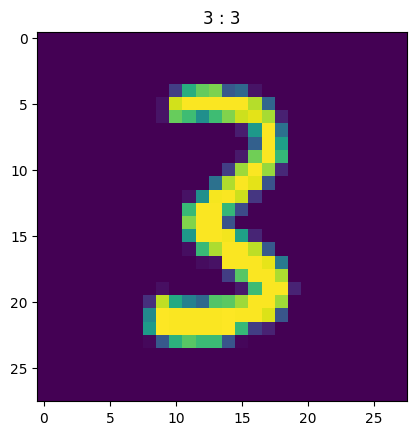

In [11]:
# 5-main
"""
Main file
"""
# Force Seed - fix for Keras
SEED = 0
# import matplotlib.pyplot as plt
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
# import tensorflow as tf
tf.set_random_seed(SEED)
# import tensorflow.keras as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.backend.set_session(sess)

lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))
Y_train = lib['Y_train']
Y_train_oh = K.utils.to_categorical(Y_train, num_classes=10)
X_valid = lib['X_valid']
X_valid_c = X_valid.reshape((-1, h, w, 1))
Y_valid = lib['Y_valid']
Y_valid_oh = K.utils.to_categorical(Y_valid, num_classes=10)
X = K.Input(shape=(h, w, 1))
model = lenet5(X)
batch_size = 32
epochs = 5
model.fit(X_train_c, Y_train_oh, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_valid_c, Y_valid_oh))
Y_pred = model.predict(X_valid_c)
print(Y_pred[0])
Y_pred = np.argmax(Y_pred, 1)
plt.imshow(X_valid[0])
plt.title(str(Y_valid[0]) + ' : ' + str(Y_pred[0]))
plt.show()